In [1]:
from pathlib import Path
import random

from utils import compare_metadata, generate_plots

from librep.datasets.har.loaders import PandasMultiModalLoader


/home/patrick/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
standartized_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}

In [3]:
raw_view_path = Path("../data/raw_balanced/RealWorld")
processed_view_path = Path("../data/standartized_balanced/RealWorld")

train_raw, validation_raw, test_raw = PandasMultiModalLoader(raw_view_path).load(
    label="standard activity code"
)
train_processed, validation_processed, test_processed = PandasMultiModalLoader(
    processed_view_path
).load(label="standard activity code")


In [4]:
compare_metadata(
    train_raw.data,
    train_processed.data,
    ["user", "standard activity code", "window"],
)

True

[1374, 10948, 4009, 7500, 9197]


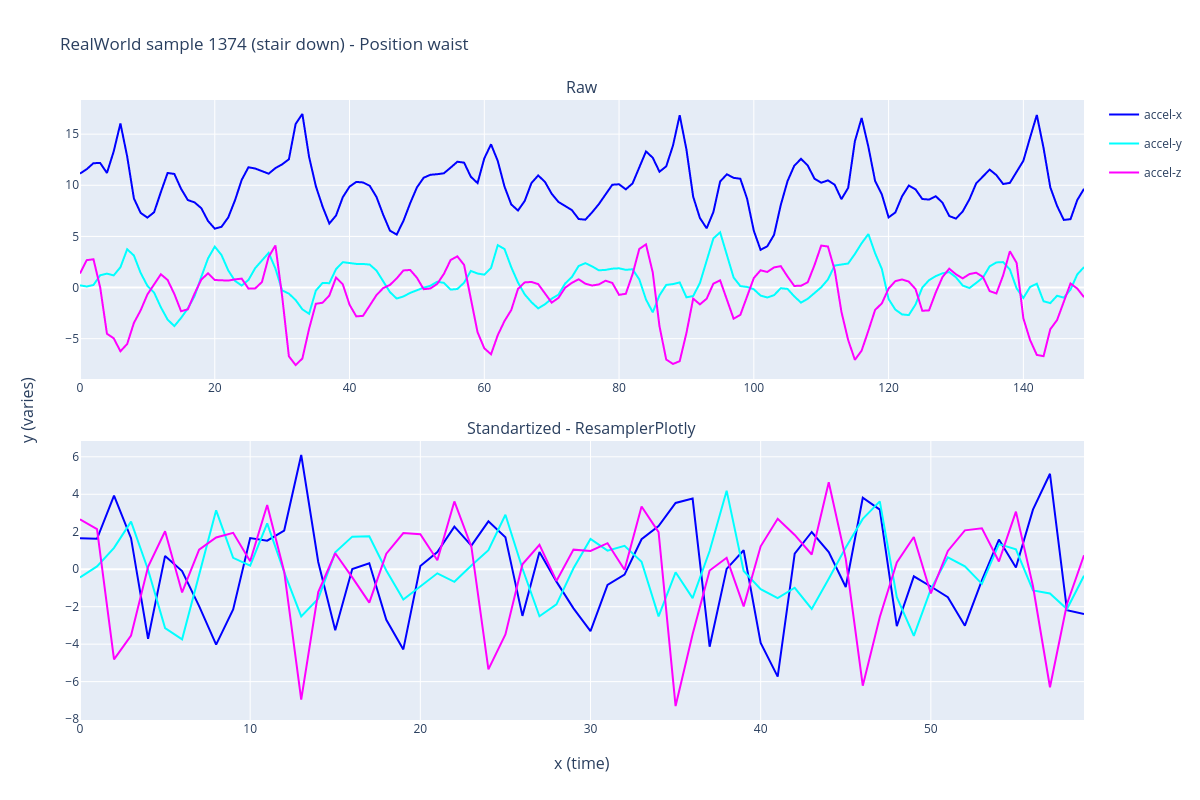

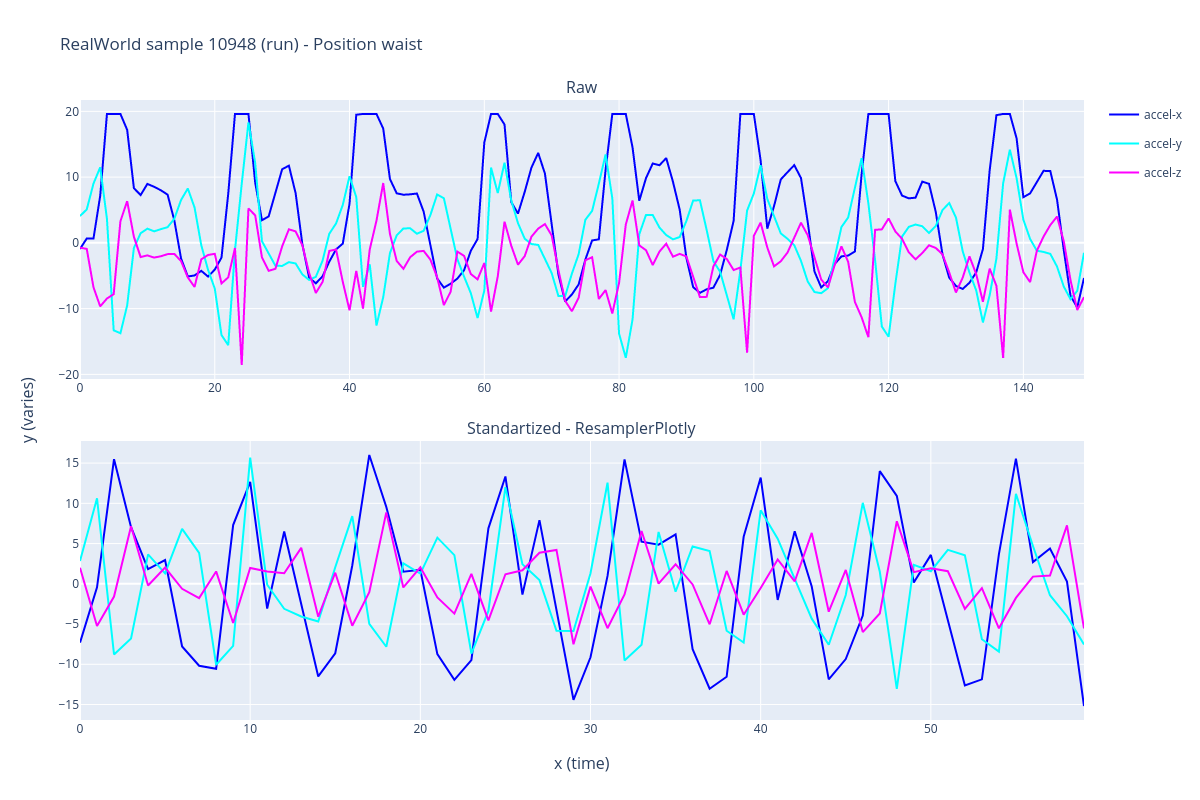

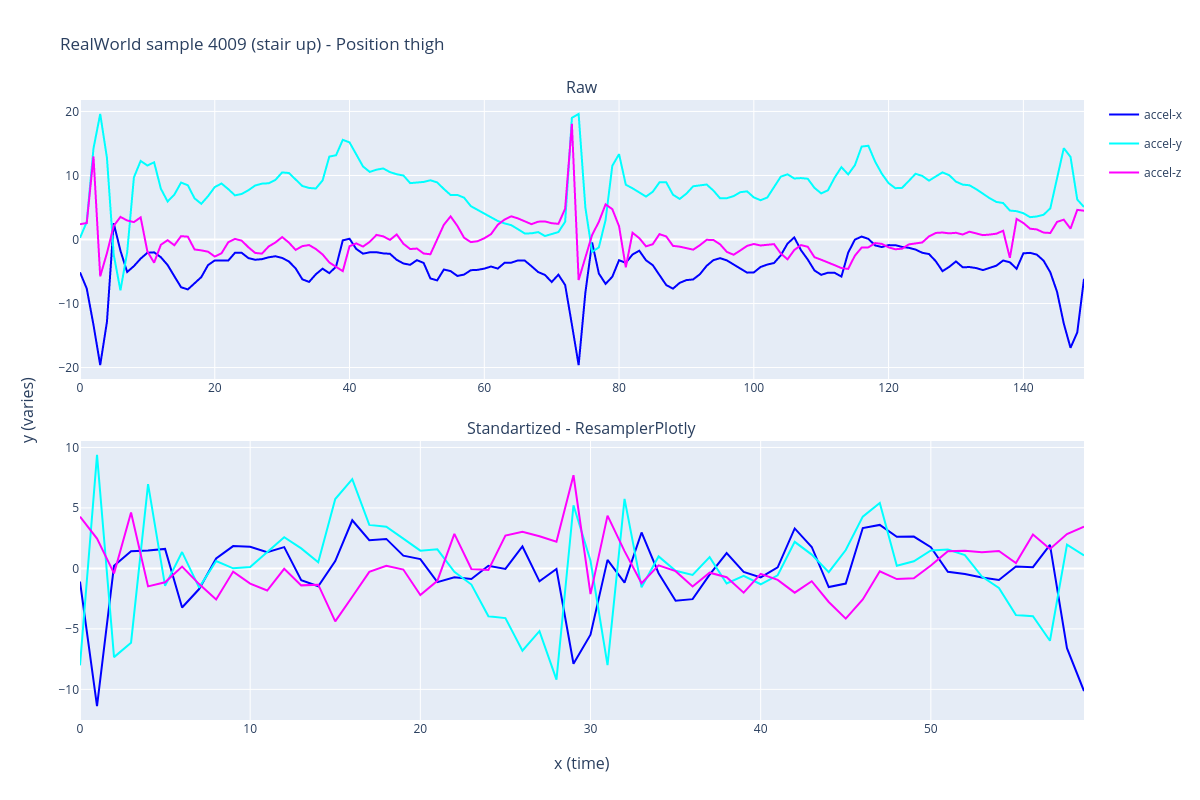

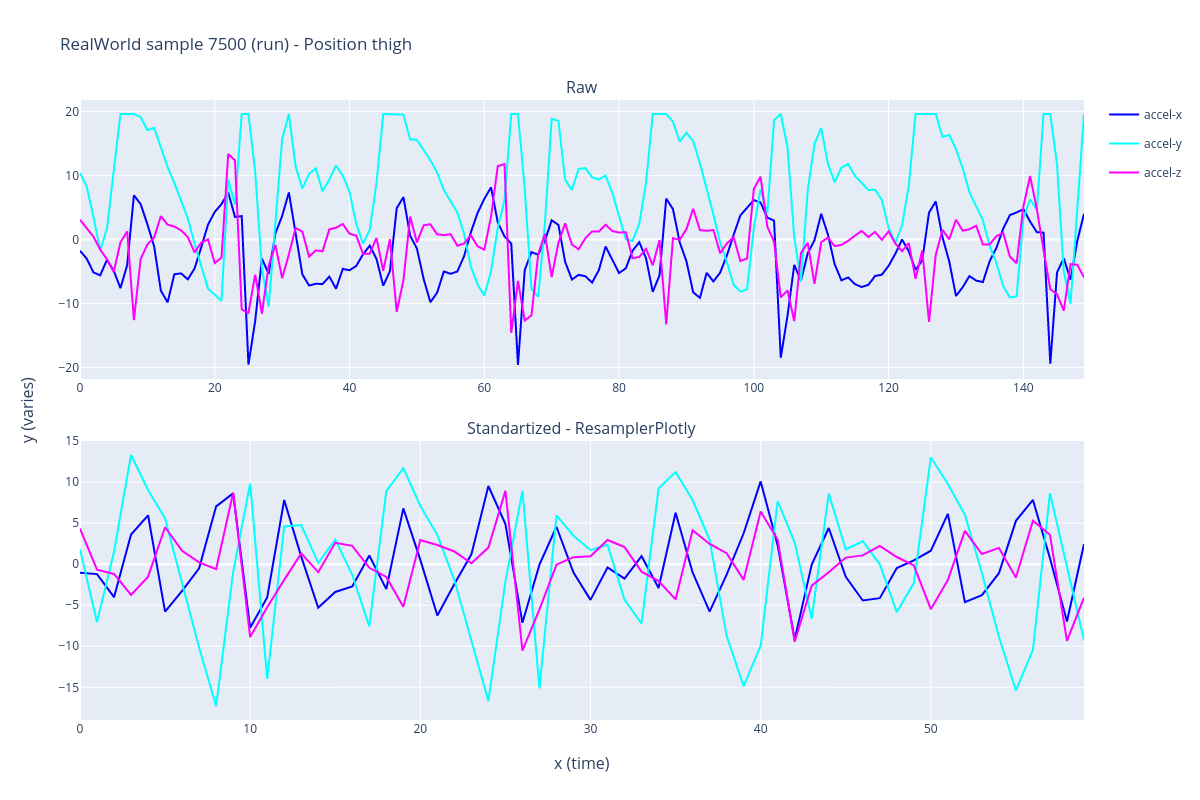

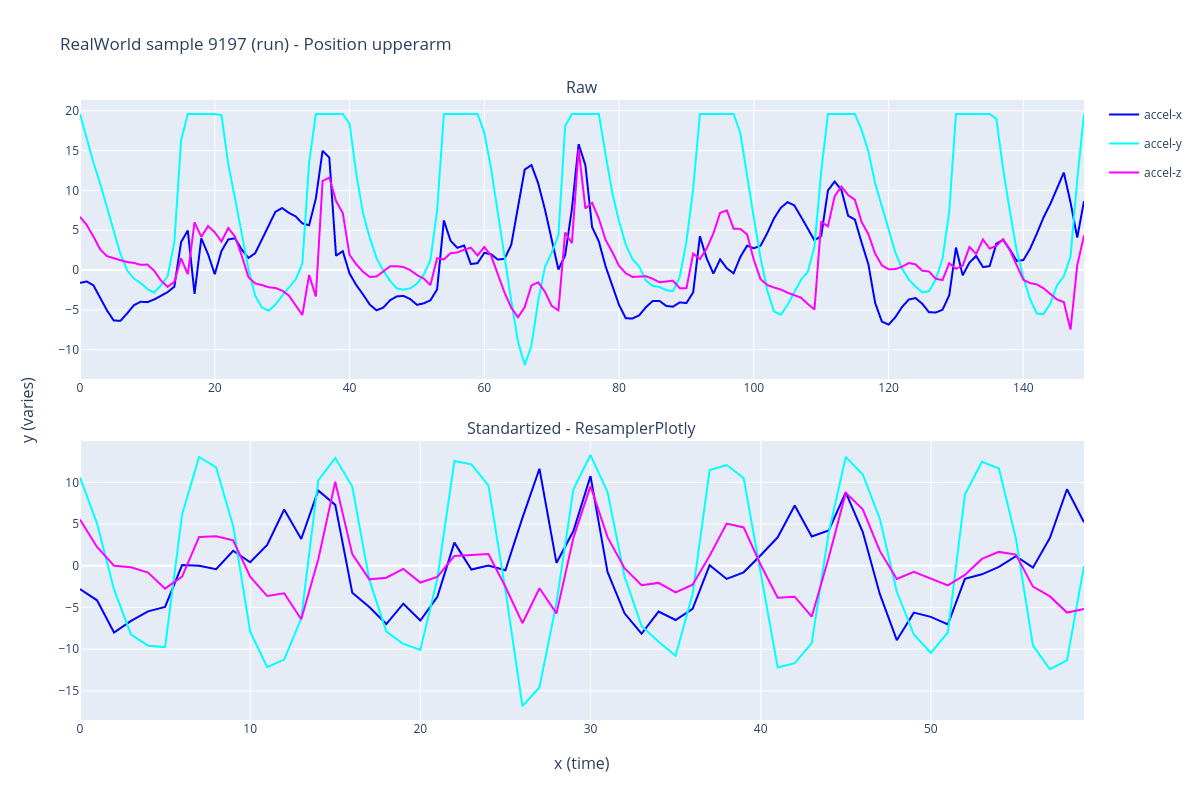

In [5]:
selected_samples = random.sample(range(len(train_raw)), 5)
print(selected_samples)

for i in selected_samples:
    label = standartized_codes[train_raw[i][1]]
    position = train_raw.data.iloc[i,:]["position"]

    fig = generate_plots(
        train_raw,
        train_processed,
        sample_no=i,
        windows=["accel-x", "accel-y", "accel-z"],
        height=800,
        width=1200,
        names=["Raw", "Standartized - ResamplerPlotly"],
        vertical_spacing=0.1,
        title=f"RealWorld sample {i} ({label}) - Position {position}",
        x_title="x (time)",
        y_title="y (varies)",
    )
    fig.show("png")


In [6]:
from librep.transforms.fft import FFT
from librep.datasets.multimodal.operations import DatasetWindowedTransform

transformer = DatasetWindowedTransform(transform=FFT(centered=True), do_fit=False, new_suffix=".fft")
fft_train_raw, fft_validation_raw, fft_test_raw = transformer(train_raw), transformer(validation_raw), transformer(test_raw)
fft_train_processed, fft_validation_processed, fft_test_processed = transformer(train_processed), transformer(validation_processed), transformer(test_processed)

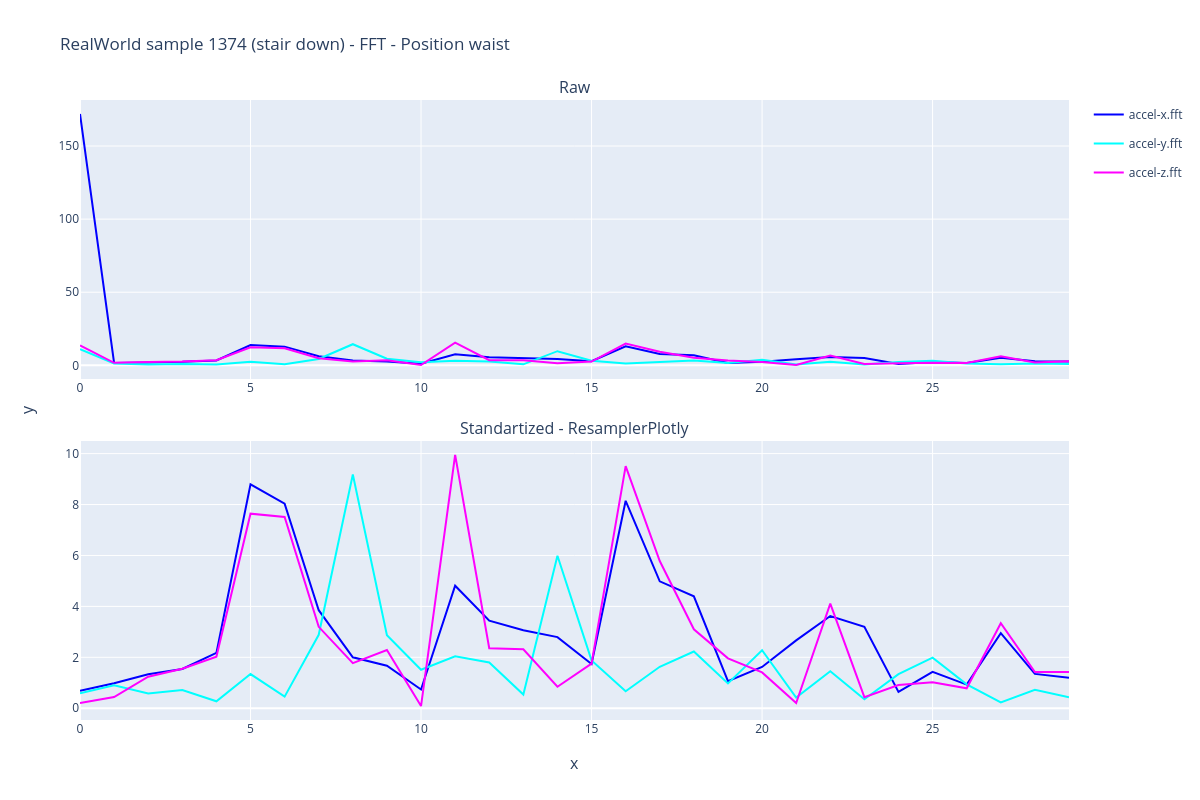

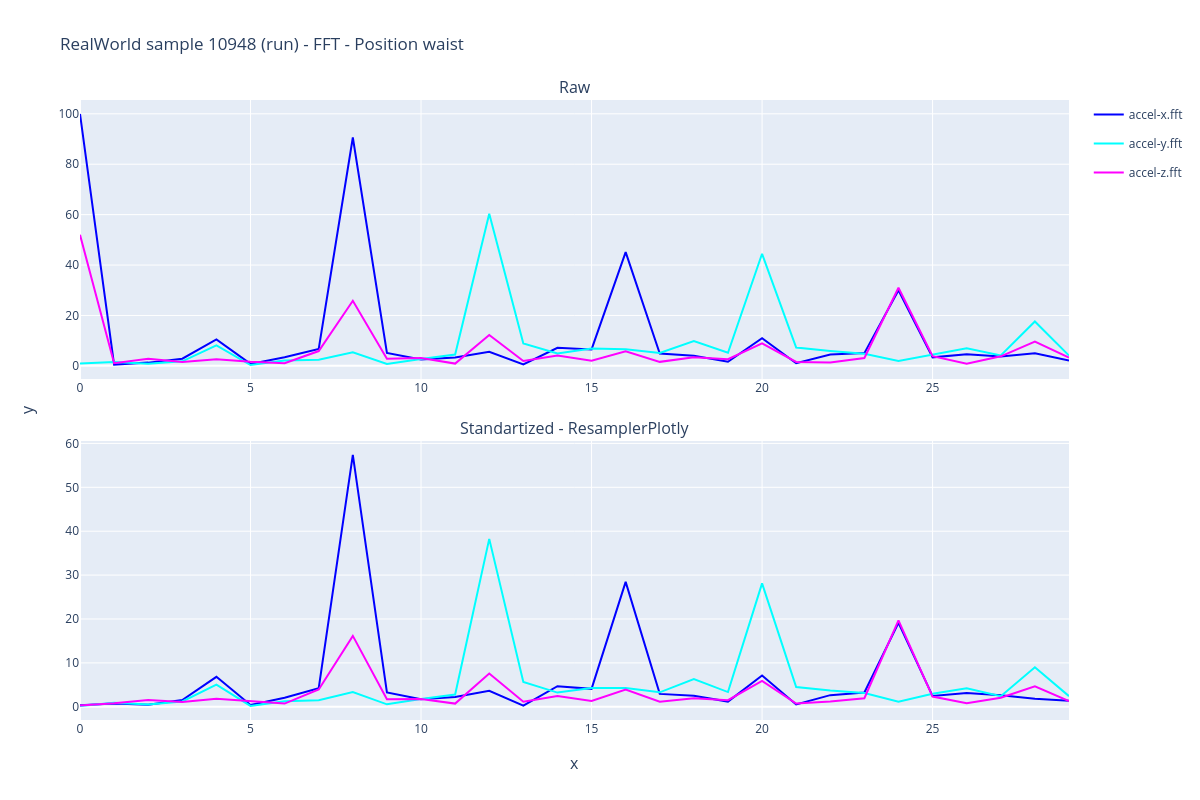

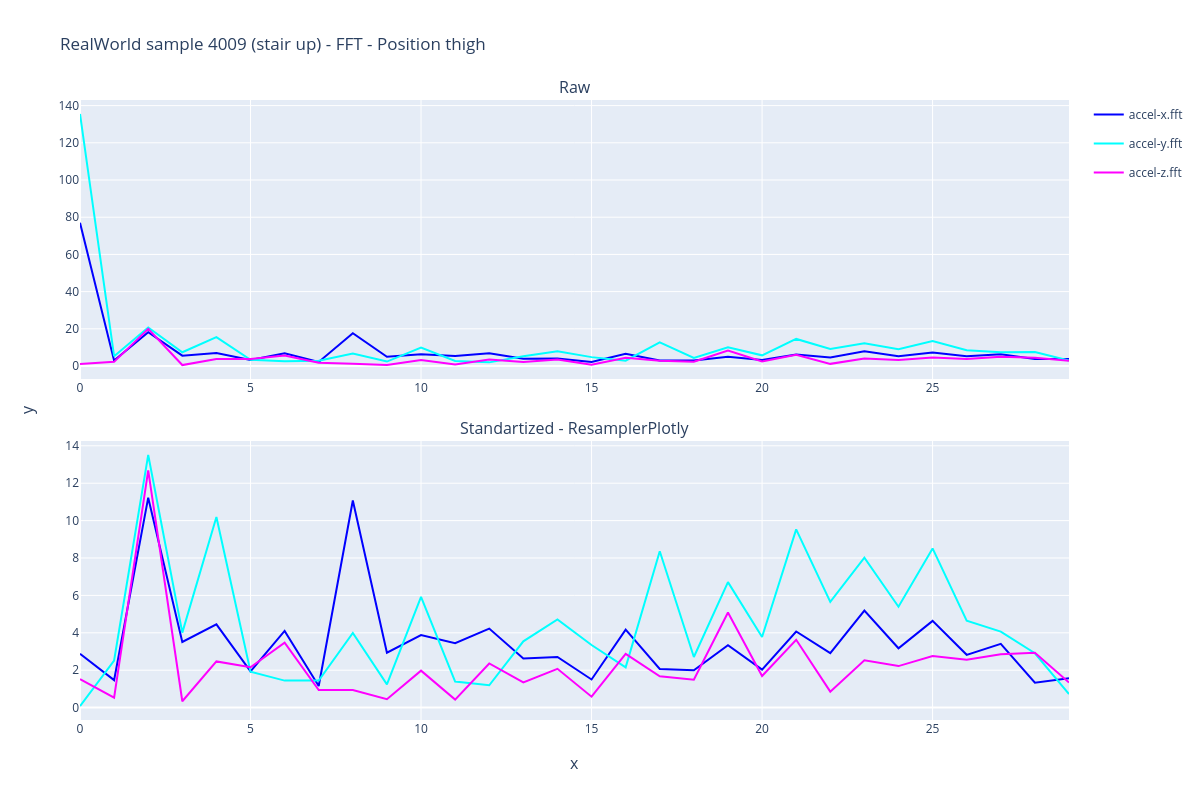

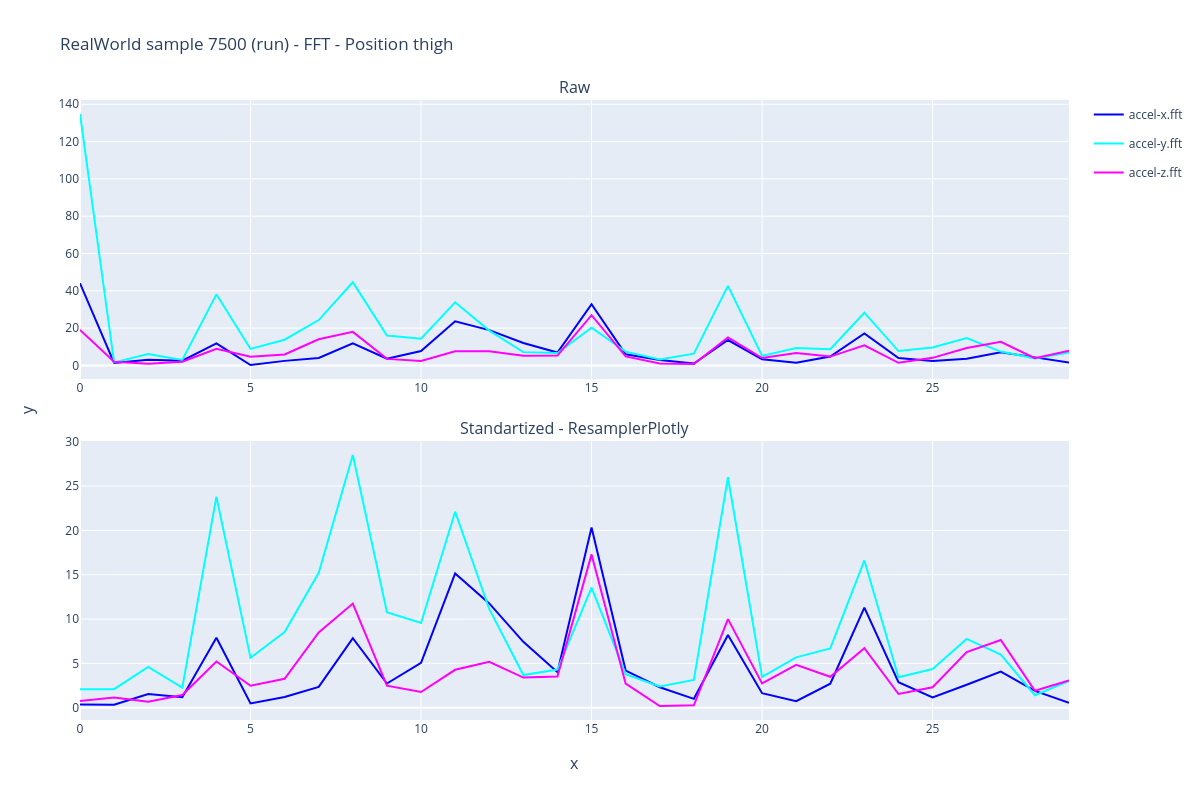

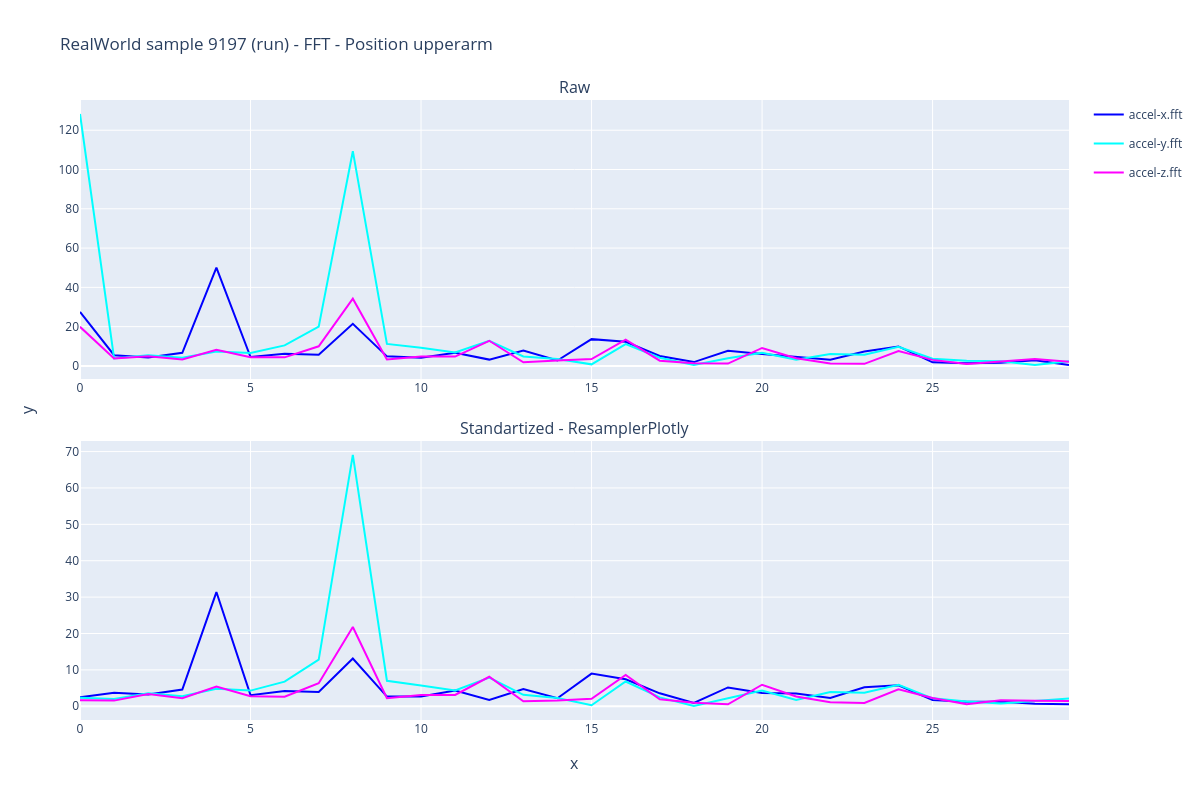

In [7]:
for i in selected_samples:
    label = standartized_codes[train_raw[i][1]]
    position = train_raw.data.iloc[i,:]["position"]

    fig = generate_plots(
        fft_train_raw,
        fft_train_processed,
        sample_no=i,
        windows=["accel-x.fft", "accel-y.fft", "accel-z.fft"],
        height=800,
        width=1200,
        names=["Raw", "Standartized - ResamplerPlotly"],
        vertical_spacing=0.1,
        title=f"RealWorld sample {i} ({label}) - FFT - Position {position}",
        x_title="x",
        y_title="y",
        the_slice=slice(0, 30, 1)
    )
    fig.show("png")

In [8]:
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP
from librep.datasets.multimodal.operations import (
    DatasetFitter,
    DatasetPredicter,
    DatasetY,
    DatasetEvaluator,
    DatasetTransformer,
)
from librep.metrics.report import ClassificationReport


def train_rf(train_dset, test_dset, use_umap=False):
    if use_umap:
        umap_model = UMAP(n_neighbors=5, n_components=5, metric="euclidean")
        DatasetFitter(umap_model, use_y=False)(train_dset)
        train_dset = DatasetTransformer(umap_model)(train_dset)
        test_dset = DatasetTransformer(umap_model)(test_dset)
    
    model = RandomForestClassifier()
    DatasetFitter(model, use_y=True)(train_dset)
    y_pred = DatasetPredicter(model)(test_dset)
    y_true = DatasetY()(test_dset)
    return DatasetEvaluator(ClassificationReport(normalize="all"))(y_true, y_pred)


# Classification without dimension reduction

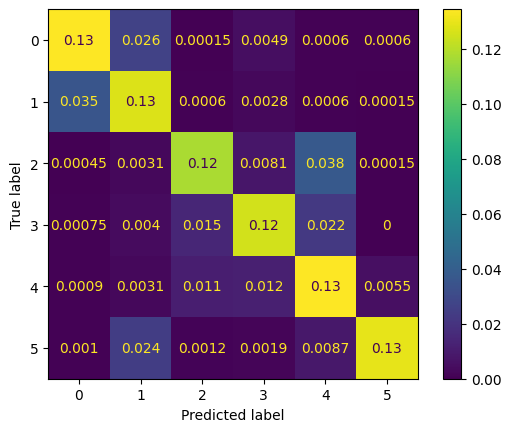

{'accuracy': 0.7671458520515124, 'f1 score (weighted)': 0.7696903783107566, 'f1 score (micro)': 0.7671458520515124, 'f1 score (macro)': 0.7696903783107566, 'confusion matrix': [[895, 176, 1, 33, 4, 4], [235, 850, 4, 19, 4, 1], [3, 21, 783, 54, 251, 1], [5, 27, 98, 834, 149, 0], [6, 21, 74, 78, 897, 37], [7, 163, 8, 13, 58, 864]]}


In [9]:
fft_train_validation_raw = fft_train_raw.concatenate(fft_validation_raw)
result = train_rf(fft_train_validation_raw, fft_test_raw)
print(result)

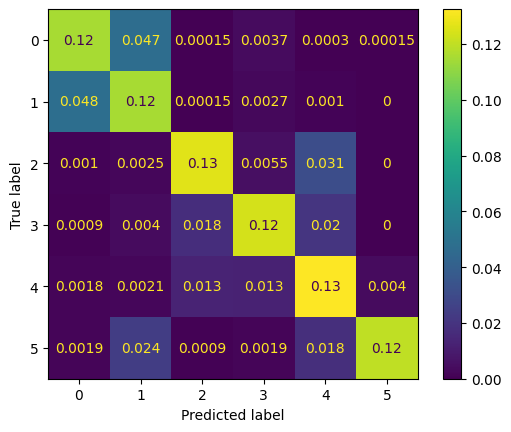

{'accuracy': 0.7331536388140162, 'f1 score (weighted)': 0.7373788395661262, 'f1 score (micro)': 0.7331536388140162, 'f1 score (macro)': 0.7373788395661262, 'confusion matrix': [[769, 315, 1, 25, 2, 1], [319, 768, 1, 18, 7, 0], [7, 17, 844, 37, 208, 0], [6, 27, 117, 828, 135, 0], [12, 14, 89, 86, 885, 27], [13, 160, 6, 13, 119, 802]]}


In [10]:
fft_train_validation_processed = fft_train_processed.concatenate(fft_validation_processed)
result = train_rf(fft_train_validation_processed, fft_test_processed)
print(result)

# Classification with dimension reduction

/home/patrick/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



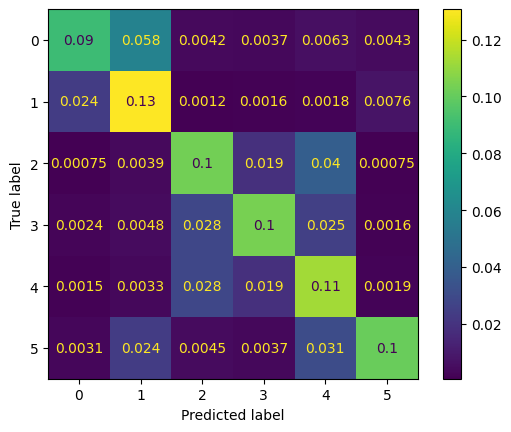

{'accuracy': 0.6415094339622641, 'f1 score (weighted)': 0.6435256683231576, 'f1 score (micro)': 0.6415094339622641, 'f1 score (macro)': 0.6435256683231575, 'confusion matrix': [[600, 389, 28, 25, 42, 29], [158, 873, 8, 11, 12, 51], [5, 26, 689, 124, 264, 5], [16, 32, 190, 695, 169, 11], [10, 22, 190, 124, 754, 13], [21, 158, 30, 25, 206, 673]]}


In [11]:
fft_train_validation_raw = fft_train_raw.concatenate(fft_validation_raw)
result = train_rf(fft_train_validation_raw, fft_test_raw, use_umap=True)
print(result)

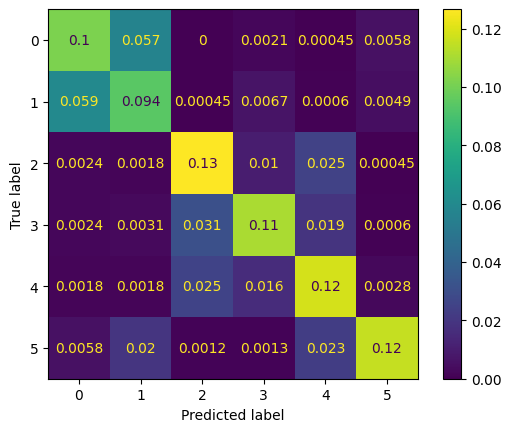

{'accuracy': 0.6675651392632524, 'f1 score (weighted)': 0.6703008415696824, 'f1 score (micro)': 0.6675651392632524, 'f1 score (macro)': 0.6703008415696825, 'confusion matrix': [[679, 378, 0, 14, 3, 39], [397, 631, 3, 45, 4, 33], [16, 12, 846, 69, 167, 3], [16, 21, 207, 737, 128, 4], [12, 12, 170, 108, 792, 19], [39, 131, 8, 9, 153, 773]]}


In [12]:
fft_train_validation_processed = fft_train_processed.concatenate(fft_validation_processed)
result = train_rf(fft_train_validation_processed, fft_test_processed,   use_umap=True)
print(result)